In [1]:
i_p_str = '6'
i_m_str = '120'

In [2]:
dir_home = '/mnt/home/kvantilburg/'
dir_ceph = dir_home+'ceph/luminous-basin/'
dir_source = dir_ceph+'data/products_80610202001_orbit1_chu12_spatialARF/'
dir_events = dir_source+'event_lists/'
dir_production = dir_ceph+'data/production/'
dir_fig = '../figures/'

import sys
#sys.path.insert(0, dir_notebook)

from my_units import *
from functions_model import * 
from functions_load import *
from functions_yellin import *

i_p = int(i_p_str) # mock file number
i_m = int(i_m_str) # axion mass integer
print('i_p =',str(i_p),'| i_m =',str(i_m))

dir_proj = dir_ceph+'results/data/proj/proj_'+str(i_p)+'/'

file_rho0 = dir_proj+'rho0_'+str(i_p)+'_'+str(i_m)+'.csv'
file_proj = dir_proj+'proj_'+str(i_p)+'_'+str(i_m)+'.csv'

# time intervals [seconds]
good_time_ints = [
(  3.37603080e+08,   3.37603330e+08),
(  3.37603330e+08,   3.37603380e+08),
(  3.37603380e+08,   3.37603380e+08),
(  3.37603580e+08,   3.37603581e+08),
(  3.37603630e+08,   3.37605080e+08),
(  3.37605081e+08,   3.37605230e+08)]
exposure = np.sum([interval[1]-interval[0] for interval in good_time_ints])
livetime = np.asarray([1501.16599845754, 1481.86081041239])/exposure # effective fractional livetime of A and B
duration = np.max(good_time_ints)- np.min(good_time_ints)

# energy bins [units = keV]
sigma_E = 0.166 # energy resolution [keV]
n_sigma_E = 3
width_E = 0.04 # energy bin width is 40 keV
bins_E = np.arange(1.6,200.01,width_E)
list_m = np.arange(3,40,0.1)
m = list_m[i_m]  # axion mass [keV]

# fiducial solar position 
ra_sun_fid = 170.66855149 * degree
dec_sun_fid = 4.02092024 * degree
# error on solar position 
sigma_sun = 2 * arcmin
# shift in solar position over duration starting from t_min
delta_ra_sun = 0.01962028 * degree
delta_dec_sun = -0.00835105 * degree
t_min = 3.37603341e+08
sigma_sun = 2*arcmin # error on solar position

list_file_events = np.sort([dir_events+file for file in listdir(dir_events)])
file_box_centers = dir_source+'box_centers.txt'
list_file_arf = [dir_source+'arfs/'+file for file in listdir(dir_source+'arfs/')]

i_p = 6 | i_m = 120


In [3]:
vec_r = np.linspace(0,3*sigma_sun,10)
arr_pos_sun = []
for i,r in enumerate(vec_r):
    for j in range(i+1):
        if i % 2 == 0:
            phi = 2*np.pi * (j/(i+1))
        else:
            phi = 2*np.pi * ((j+0.5)/(i+1))
        arr_pos_sun.append([r * np.cos(phi), r * np.sin(phi)])
arr_pos_sun = np.asarray(arr_pos_sun)

cos_fac = (np.abs(np.cos(dec_sun_fid)))

vec_ra_offset =  cos_fac**(-1) * np.arange(-3*sigma_sun,+3*sigma_sun+1e-10,0.3*sigma_sun)
vec_dec_offset = np.arange(-3*sigma_sun,+3*sigma_sun+1e-10,0.3*sigma_sun)
arr_pos_sun = np.asarray([[ra,dec] for ra in vec_ra_offset for dec in vec_dec_offset])
arr_pos_sun = arr_pos_sun[arr_pos_sun[:,0]**2 * cos_fac**2 + arr_pos_sun[:,1]**2 <= (3*sigma_sun*(1+1e-6))**2]

vec_ra_sun_0 = ra_sun_fid + arr_pos_sun[:,0]
vec_dec_sun_0 = dec_sun_fid + arr_pos_sun[:,1]

# initial solar position
ra_sun_0 = vec_ra_sun_0[i_p]
dec_sun_0 = vec_dec_sun_0[i_p]

In [4]:
##### load data #####
print('m = '+str(m)[0:8]+': initialized, loading data...')

df_box = load_box(file_box_centers)
rotation = df_box['rotation'].iloc[0] * degree
df_arf = load_arf_m(list_file_arf,bins_E,df_box,m,sigma_E,n_sigma_E)
df_events_m = load_events_m(list_file_events,m,sigma_E,n_sigma_E)

t = df_events_m['t'].to_numpy()
E = df_events_m['E'].to_numpy()
ra = df_events_m['ra'].to_numpy()
dec = df_events_m['dec'].to_numpy()
x,y = map_x_y_from_ra_dec(ra,dec,rotation)

m = 15.00000: initialized, loading data...


run the cell below to test projections

## Solar Projection Plot

In [5]:
ra_sun_fid/degree, dec_sun_fid/degree

(170.66855149, 4.02092024)

In [6]:
i_p = 160 # this is the fiducial solar position index
vec_ra_sun_0[i_p]/degree,vec_dec_sun_0[i_p]/degree

(170.66855149, 4.04092024)

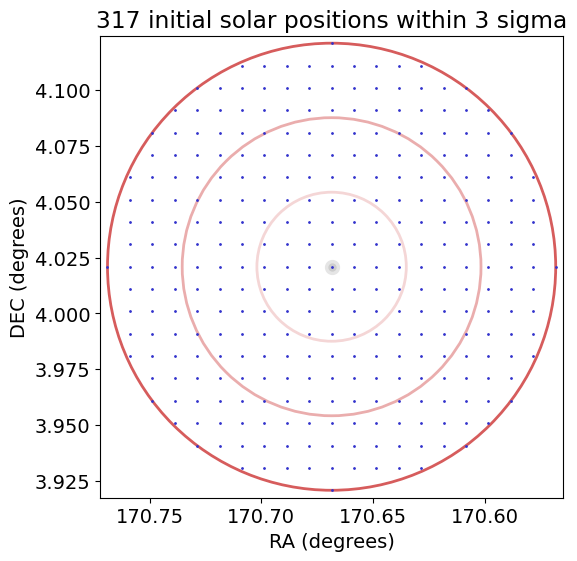

In [9]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(ra_sun_fid/degree,dec_sun_fid/degree,color=(0,0,0,0.1),lw=5);

ellipse_1 = mp.patches.Ellipse(xy=(ra_sun_fid/degree,dec_sun_fid/degree),
                                       width=cos_fac**(-1)*2*sigma_sun/degree, height=2*sigma_sun/degree, 
                                       edgecolor=(0.8,0.2,0.2,0.2), fc='None', lw=2)
ellipse_2 = mp.patches.Ellipse(xy=(ra_sun_fid/degree,dec_sun_fid/degree),
                                       width=cos_fac**(-1)*2*2*sigma_sun/degree, height=2*2*sigma_sun/degree, 
                                       edgecolor=(0.8,0.2,0.2,0.4), fc='None', lw=2)
ellipse_3 = mp.patches.Ellipse(xy=(ra_sun_fid/degree,dec_sun_fid/degree),
                                       width=cos_fac**(-1)*3*2*sigma_sun/degree, height=3*2*sigma_sun/degree, 
                                       edgecolor=(0.8,0.2,0.2,0.8), fc='None', lw=2)
ax.add_patch(ellipse_1); ax.add_patch(ellipse_2); ax.add_patch(ellipse_3);
ax.set_aspect(1);
ax.set_xlim(ra_sun_fid/degree + cos_fac**(-1)*3.1*sigma_sun/degree,ra_sun_fid/degree - cos_fac**(-1)*3.1*sigma_sun/degree)
ax.set_ylim(dec_sun_fid/degree - 3.1*sigma_sun/degree, dec_sun_fid/degree + 3.1*sigma_sun/degree)
ax.scatter(vec_ra_sun_0/degree,vec_dec_sun_0/degree,color=(0.2,0.2,0.8,1),s=1);
ax.set_xlabel('RA (degrees)'); ax.set_ylabel('DEC (degrees)');
ax.set_title(str(len(arr_pos_sun))+' initial solar positions within 3 sigma');
fig.savefig(dir_fig+'solar_positions.pdf', bbox_inches='tight', pad_inches = 0)

## Event Plot

In [10]:
df_events = load_events(list_file_events)
df_events = df_events[df_events['E']>=3].reset_index(drop=True)
df_events_20 = df_events[df_events['E']<=20]
df_events_20

,detector,t,E,ra,dec
2,A,3.376033e+08,3.04,171.046690,3.842475
3,A,3.376033e+08,3.00,170.817417,3.916901
8,A,3.376033e+08,3.76,170.856427,3.899831
9,A,3.376034e+08,3.12,170.965931,3.898465
11,A,3.376034e+08,3.24,170.900229,3.964697
...,...,...,...,...,...
3007,B,3.376052e+08,3.28,170.870115,3.939433
3010,B,3.376052e+08,9.56,170.953612,3.800141
3011,B,3.376052e+08,7.40,170.874906,3.976305
3013,B,3.376052e+08,3.04,170.807151,3.919632


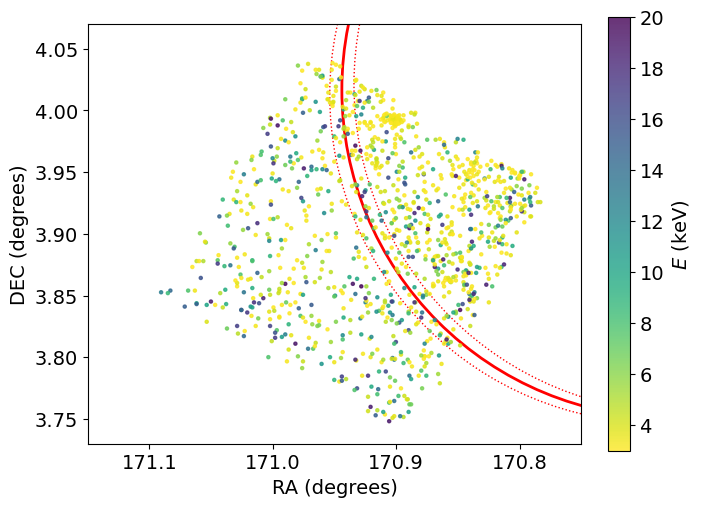

In [116]:
cmap = mp.cm.get_cmap('viridis_r').copy()
fig, ax = plt.subplots(1,1,figsize=(7,7))
ellipse0 = mp.patches.Ellipse(((ra_sun_fid+0*delta_ra_sun)/degree,(dec_sun_fid+0*delta_dec_sun)/degree), 
                              width=2*RSolar/AU/degree/np.cos(dec_sun_fid*np.pi/180), 
                              height= 2*RSolar/AU/degree,
                              color='red', ls='dotted', lw=1, fill=False)
ellipse1 = mp.patches.Ellipse(((ra_sun_fid+0.5*delta_ra_sun)/degree,(dec_sun_fid+0.5*delta_dec_sun)/degree), 
                              width=2*RSolar/AU/degree/np.cos(dec_sun_fid*np.pi/180), 
                              height= 2*RSolar/AU/degree,
                              color='red', ls='solid', lw=2,fill=False)
ellipse2 = mp.patches.Ellipse(((ra_sun_fid+delta_ra_sun)/degree,(dec_sun_fid+delta_dec_sun)/degree), 
                              width=2*RSolar/AU/degree/np.cos(dec_sun_fid*np.pi/180), 
                              height= 2*RSolar/AU/degree,
                              color='red', ls='dotted', lw=1, fill=False)
ax.add_artist(ellipse0); ax.add_artist(ellipse1); ax.add_artist(ellipse2);
sp1 = ax.scatter(df_events_20['ra'],df_events_20['dec'],s = 5, alpha = 0.8, c=(df_events_20['E']),cmap='viridis_r',vmin = 3, vmax = 20)
ax.set_xlabel('RA (degrees)'); ax.set_ylabel('DEC (degrees)');
delta_FOV = 0.34
center_FOV = [170.93,3.9]
ax.set_xlim(center_FOV[0]+delta_FOV/2,center_FOV[0]-delta_FOV/2);
ax.set_ylim(center_FOV[1]-delta_FOV/2,center_FOV[1]+delta_FOV/2);ax.set_xlim(171.15,170.75);
ax.set_aspect(1)
fig.colorbar(sp1,ax=ax,fraction=0.04).set_label('$E$ (keV)')
fig.savefig(dir_fig+'raw_data_scatter.pdf', bbox_inches='tight', pad_inches = 0)

## Signal plot

In [33]:
idx_E = 147
bins_E[idx_E]

7.480000000000006

In [51]:
df_arf_E = df_arf[df_arf['idx_E']==idx_E]
df_arf_A = df_arf_E[df_arf_E['detector']=='A']
df_arf_B = df_arf_E[df_arf_E['detector']=='B']
df_arf_A,df_arf_B

(     detector  idx_E  i1  i2       ra      dec         arf
 1859        A    147  -6  -6  170.889  3.75981  111.656998
 1860        A    147  -6  -5  170.881  3.77425   81.747238
 1861        A    147  -6  -4  170.872  3.78868  136.090027
 1862        A    147  -6  -3  170.864  3.80311  134.800781
 1863        A    147  -6  -2  170.856  3.81755  237.031265
 ...       ...    ...  ..  ..      ...      ...         ...
 2023        A    147   6   2  170.996  3.97528   99.237541
 2024        A    147   6   3  170.987  3.98972   59.709209
 2025        A    147   6   4  170.979  4.00415  117.076454
 2026        A    147   6   5  170.971  4.01858   68.442741
 2027        A    147   6   6  170.962  4.03302   66.483643
 
 [169 rows x 7 columns],
      detector  idx_E  i1  i2       ra      dec         arf
 5915        B    147  -6  -6  170.902  3.75640  128.857468
 5916        B    147  -6  -5  170.894  3.77083  147.841095
 5917        B    147  -6  -4  170.886  3.78526  153.904724
 5918        

In [38]:
livetime * exposure * arcmin**2 / (degree**2)

array([0.41699056, 0.411628  ])

In [76]:
vec_T = T_flux_template(t_min+duration/2,df_arf_E['ra'],df_arf_E['dec'],ra_sun_fid,dec_sun_fid,delta_ra_sun,delta_dec_sun,t_min,duration)

In [77]:
vec_livetime = np.concatenate([np.asarray(len(df_arf_E)//2 * [livetime[0]]), np.asarray(len(df_arf_E)//2 * [livetime[1]])])
vec_fac = vec_T * vec_livetime * exposure * arcmin**2 / (degree**2)

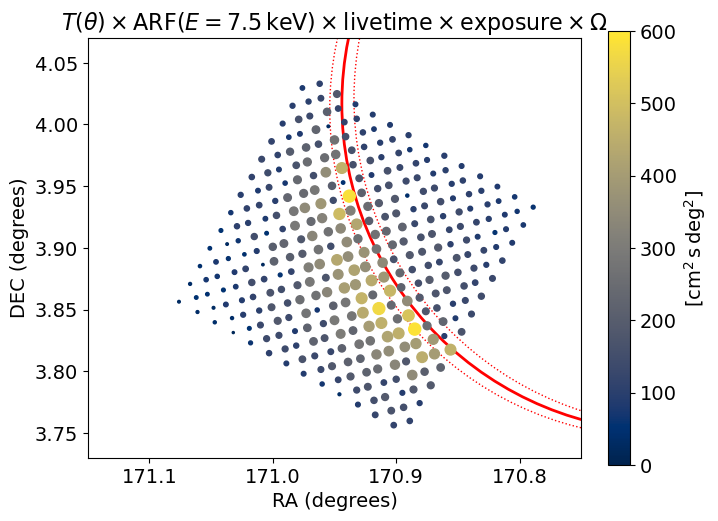

In [115]:
cmap = mp.cm.get_cmap('cividis').copy()
fig, ax = plt.subplots(1,1,figsize=(7,7))
ellipse0 = mp.patches.Ellipse(((ra_sun_fid+0*delta_ra_sun)/degree,(dec_sun_fid+0*delta_dec_sun)/degree), 
                              width=2*RSolar/AU/degree/np.cos(dec_sun_fid*np.pi/180), 
                              height= 2*RSolar/AU/degree,
                              color='red', ls='dotted', lw=1, fill=False)
ellipse1 = mp.patches.Ellipse(((ra_sun_fid+0.5*delta_ra_sun)/degree,(dec_sun_fid+0.5*delta_dec_sun)/degree), 
                              width=2*RSolar/AU/degree/np.cos(dec_sun_fid*np.pi/180), 
                              height= 2*RSolar/AU/degree,
                              color='red', ls='solid', lw=2,fill=False)
ellipse2 = mp.patches.Ellipse(((ra_sun_fid+delta_ra_sun)/degree,(dec_sun_fid+delta_dec_sun)/degree), 
                              width=2*RSolar/AU/degree/np.cos(dec_sun_fid*np.pi/180), 
                              height= 2*RSolar/AU/degree,
                              color='red', ls='dotted', lw=1, fill=False)
ax.add_artist(ellipse0); ax.add_artist(ellipse1); ax.add_artist(ellipse2);
sp2 = ax.scatter(df_arf_E['ra'],df_arf_E['dec'],
                 s=75*df_arf_E['arf'] * vec_fac / np.max(df_arf_E['arf'] * vec_fac),
                 c=df_arf_E['arf'] * vec_fac,cmap=cmap,vmin=0,vmax=600)
ax.set_xlabel('RA (degrees)'); ax.set_ylabel('DEC (degrees)');
delta_FOV = 0.34
center_FOV = [170.93,3.9]
ax.set_xlim(center_FOV[0]+delta_FOV/2,center_FOV[0]-delta_FOV/2);
ax.set_ylim(center_FOV[1]-delta_FOV/2,center_FOV[1]+delta_FOV/2);ax.set_xlim(171.15,170.75);
ax.set_aspect(1)
ax.set_title(r'$T(\theta) \times \mathrm{ARF}(E=7.5\,\mathrm{keV}) \times \mathrm{livetime} \times \mathrm{exposure} \times \Omega$',fontsize=16)
cbar = fig.colorbar(sp2,ax=ax,fraction=0.04).set_label(r'$[\mathrm{cm^{2} \, s \, deg^{2}}]$')

fig.savefig(dir_fig+'expected_counts.pdf', bbox_inches='tight', pad_inches = 0)